# Introduction to Tensorflow

by Ivan Yurchenko ([ivanyu.me](https://ivanyu.me/), [@ivan0yu](https://twitter.com/ivan0yu) on Twitter, [ivanyu](https://github.com/ivanyu) on GitHub).

![TensorFlow logo](images/logo.png)

## What is TensorFlow

TensorFlow is a __general-purpose framework__ for __distributed numerical computations__. It uses the concept of __computational graphs__, which can be created and run on multiple devices (CPU, GPU) and computers.

## Tensors

The central unit of data in TensorFlow is the __tensor__. A tensor consists of a set of primitive values shaped into an array of any number of dimensions. A tensor's __rank__ is its number of dimensions.
![A tensor](images/tensor.png)

### Examples of tensors

```python
3 # a rank 0 tensor; this is a scalar with shape []

[1. ,2., 3.] # a rank 1 tensor; this is a vector with shape [3]

[[1., 2., 3.],
 [4., 5., 6.]] # a rank 2 tensor; a matrix with shape [2, 3]

[[[1., 2., 3.]],
 [[7., 8., 9.]]] # a rank 3 tensor with shape [2, 1, 3]
```

## Starting with TensorFlow

In [1]:
# Usual Pythonic stuff
from __future__ import print_function
from __future__ import division

import tensorflow as tf

### Let's define a vary simple computational graph

In [2]:
tf.reset_default_graph()
node1 = tf.constant(3.0, tf.float32, name='a')
node2 = tf.constant(4.0, name='b') # also tf.float32 implicitly
print(node1)
print(node2)

node3 = tf.add(node1, node2, name='a_plus_b')
print(node3)

Tensor("a:0", shape=(), dtype=float32)
Tensor("b:0", shape=(), dtype=float32)
Tensor("a_plus_b:0", shape=(), dtype=float32)


In [3]:
tf.get_default_graph().get_operations()

[<tf.Operation 'a' type=Const>,
 <tf.Operation 'b' type=Const>,
 <tf.Operation 'a_plus_b' type=Add>]

### Sessions

To actually evaluate the nodes, we must run the computational graph within a __session__. A session encapsulates the control and state of the TensorFlow runtime.

In [4]:
sess = tf.Session()
print(sess.run([node1, node2]))

[3.0, 4.0]


In [5]:
print(sess.run([node3]))

[7.0]


### Placeholders

A graph can be parameterized to accept external inputs, known as __placeholders__. A placeholder is a promise to provide a value later.

In [6]:
tf.reset_default_graph()
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b  # + provides a shortcut for tf.add(a, b)

print(a)
print(b)
print(adder_node)

Tensor("Placeholder:0", dtype=float32)
Tensor("Placeholder_1:0", dtype=float32)
Tensor("add:0", dtype=float32)


We can evaluate this graph with multiple inputs by using the a __feed dictionary__ to specify Tensors that provide concrete values to these placeholders:

In [7]:
sess = tf.Session()
print(sess.run(adder_node, feed_dict={a: 3, b:4.5}))

# And higher dimentional:
print(sess.run(adder_node, feed_dict={
    a: [[   1,     2],
        [   3,     4]],
    b: [[  10,   100],
        [1000, 10000]]
}))

7.5
[[    11.    102.]
 [  1003.  10004.]]


### Variables

In machine learning we will typically want a model that can take arbitrary inputs, such as the one above. To make the model trainable, we need to be able to modify the graph to get new outputs with the same input. __Variables__ allow us to add trainable parameters to a graph. They are constructed with a type and initial value:

In [8]:
tf.reset_default_graph()
W = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b

In contrast to constants, to initialize all the variables in a TensorFlow program, you must explicitly call a special operation as follows:

In [9]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

In [10]:
print(sess.run(linear_model, {x:[1,2,3,4]}))

[ 0.          0.30000001  0.60000002  0.90000004]


Let's create a loss function for this simple linear regression model:

In [11]:
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, {x: [1,2,3,4], y: [0,-1,-2,-3]}))

23.66


Now let's change values of the variables `W` and `b`:

In [12]:
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
sess.run([fixW, fixb])
print(sess.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]}))

0.0


### Optimizers

TensorFlow provides __optimizers__ that slowly change each variable in order to minimize the loss function. The simplest optimizer is __gradient descent__. It modifies each variable according to the magnitude of the derivative of loss with respect to that variable. In general, computing symbolic derivatives manually is tedious and error-prone. Consequently, TensorFlow can automatically produce derivatives given only a description of the model using the function tf.gradients. For simplicity, optimizers typically do this for you. For example,

In [13]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train_op = optimizer.minimize(loss)

In [14]:
sess.run(init) # reset values to incorrect defaults

for i in range(1000):
  sess.run(train_op, {x:[1,2,3,4], y:[0,-1,-2,-3]})

print("Coefficients:", sess.run([W, b]))
print("Loss:", sess.run(loss, {x: [1,2,3,4], y: [0,-1,-2,-3]}))

Coefficients: [array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]
Loss: 5.69997e-11


## Simple MNIST recognition (TensorFlow's "Hello world")

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:
![MNIST example](images/mnist.png)

Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:
<img src="images/mnist-matrix.png" />

TensorFlow has the ability to automatically download the MNIST dataset:

In [15]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('_tmp_mnist_data', one_hot=True)

Extracting _tmp_mnist_data\train-images-idx3-ubyte.gz
Extracting _tmp_mnist_data\train-labels-idx1-ubyte.gz
Extracting _tmp_mnist_data\t10k-images-idx3-ubyte.gz
Extracting _tmp_mnist_data\t10k-labels-idx1-ubyte.gz


The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

Let's display some of them using Matplotlib:

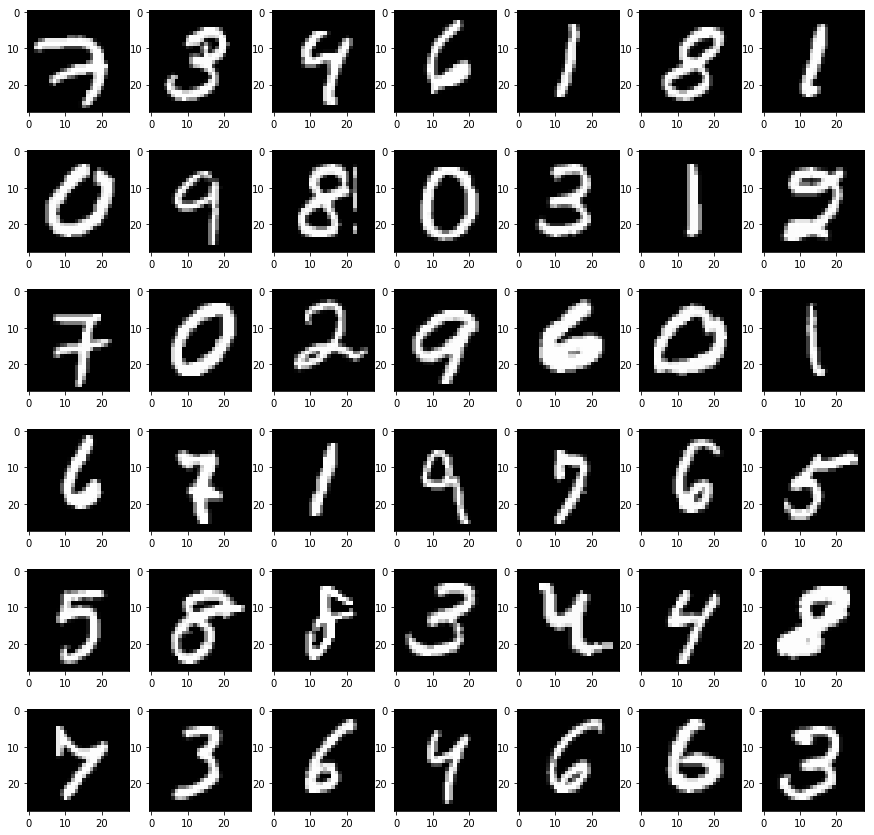

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 15))
for i in range(42):
    plt.subplot(6, 7, i + 1)
    plt.imshow(mnist.train.images[i].reshape(28,28), cmap='gray')

`mnist.train.images` is a tensor (an n-dimensional array) with a shape of `[55000, 784]`. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

<img src="images/mnist-train-xs.png" />

### Softmax Regressions

We want to be able to look at an image and give the probabilities for it being each digit. For example, our model might look at a picture of a nine and be 80% sure it's a nine, but give a 5% chance to it being an eight (because of the top loop) and a bit of probability to all the others because it isn't 100% sure.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do, because softmax gives us a list of values between 0 and 1 that add up to 1.

A softmax regression has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities.

To tally up the evidence that a given image is in a particular class, we do a weighted sum of the pixel intensities. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor.

The following diagram shows the weights one model learned for each of these classes. Red represents negative weights, while blue represents positive weights.

<img src="images/softmax-weights.png" />

We also add some extra evidence called a __bias__. Basically, we want to be able to say that some things are more likely independent of the input. The result is that the evidence for a class $i$ given an input $x$ is:

$$\text{evidence}_i = \sum_j W_{i,~ j} x_j + b_i$$

where $W_i$ is the weights and $b_i$ is the bias for class $i$, and $j$ is an index for summing over the pixels in our input image $x$. We then convert the evidence tallies into our predicted probabilities $y$ using the "softmax" function:

$$y = \text{softmax}(\text{evidence})$$

Here softmax is serving as an "activation" or "link" function, shaping the output of our linear function into the form we want -- in this case, a probability distribution over 10 cases. You can think of it as converting tallies of evidence into probabilities of our input being in each class. It's defined as:

$$\text{softmax}(x) = \text{normalize}(\exp(x))$$

If you expand that equation out, you get:

$$\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

You can picture our softmax regression as looking something like the following, although with a lot more $x$s. For each output, we compute a weighted sum of the $x$s, add a bias, and then apply softmax.

<img src="images/softmax-regression-scalargraph.png" />

If we write that out as equations, we get:

<img src="images/softmax-regression-scalarequation.png" />

We can "vectorize" this procedure, turning it into a matrix multiplication and vector addition. This is helpful for computational efficiency.

<img src="images/softmax-regression-vectorequation.png" />

More compactly, we can just write:

$$y = \text{softmax}(Wx + b)$$

Now let's turn that into something that TensorFlow can use.

In [17]:
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, [None, 784]) # None means that a dimension can be of any length

# Weights
W = tf.Variable(tf.zeros([784, 10]))
# Biases
b = tf.Variable(tf.zeros([10]))

# Model output
y = tf.matmul(x, W) + b

# Correct output
y_ = tf.placeholder(tf.float32, [None, 10])

### Training

In order to train the model, we need to define what it means for the model to be good. We call this the cost, or the loss, and it represents how far off our model is from our desired outcome. We try to minimize that error, and the smaller the error margin, the better our model is.

One very common, very nice function to determine the loss of a model is called __"cross-entropy."__ It's defined as:

$$H_{y'}(y) = -\sum_i y'_i \log(y_i)$$

Where $y$ is our predicted probability distribution, and $y'$ is the true distribution (the one-hot vector with the digit labels).

In [18]:
cross_entropy0 = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

First, `tf.log` computes the logarithm of each element of `y`. Next, we multiply each element of `y_` with the corresponding element of `tf.log(y)`. Then `tf.reduce_sum` adds the elements in the second dimension of `y`, due to the `reduction_indices=[1]` parameter. Finally, `tf.reduce_mean` computes the mean over all the examples in the batch.

But won't use this formulation, because it is numerically unstable. Instead, we apply `tf.nn.softmax_cross_entropy_with_logits` on the unnormalized logits (e.g., we call `softmax_cross_entropy_with_logits` on `tf.matmul(x, W) + b)`, because this more numerically stable function internally computes the softmax activation.

In [19]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Now that we know what we want our model to do, it's very easy to have TensorFlow train it to do so. Because TensorFlow knows the entire graph of your computations, it can automatically use the __backpropagation algorithm__ to efficiently determine how your variables affect the loss you ask it to minimize. Then it can apply your choice of optimization algorithm to modify the variables and reduce the loss.

In [20]:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

In this case, we ask TensorFlow to minimize `cross_entropy` using the gradient descent algorithm with a learning rate of `0.1`. Gradient descent is a simple procedure, where TensorFlow simply shifts each variable a little bit in the direction that reduces the cost. But TensorFlow also provides many other optimization algorithms.

In [26]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

Each step of the loop, we get a "batch" of one hundred random data points from our training set. We run `train_step` feeding in the batches data to replace the placeholders.

Using small batches of random data is called __stochastic training__ -- in this case, __stochastic gradient descent__.

### Evaluating the model

How well does the model do?

Well, first let's figure out where we predicted the correct label. `tf.argmax` is a function which gives you the index of the highest entry in a tensor along some axis. For example, `tf.argmax(y, 1)` is the label our model thinks is most likely for each input, while `tf.argmax(y_, 1)` is the correct label. We can use `tf.equal` to check if our prediction matches the truth.

In [23]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, `[True, False, True, True]` would become `[1,0,1,1]` which would become `0.75`.

In [24]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Finally, we ask for our accuracy on our test data.

In [25]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.91


Let's evaluate the model while we train it:

In [29]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  accuracy_val, _ = sess.run([accuracy, train_step],
                             feed_dict={x: batch_xs, y_: batch_ys})

  if epoch % 50 == 0:
    print("Epoch {}, accuracy = {}".format(epoch, accuracy_val))

Epoch 0, accuracy = 0.07999999821186066
Epoch 50, accuracy = 0.8600000143051147
Epoch 100, accuracy = 0.8199999332427979
Epoch 150, accuracy = 0.8800000548362732
Epoch 200, accuracy = 0.8700000047683716
Epoch 250, accuracy = 0.8299999237060547
Epoch 300, accuracy = 0.8800000548362732
Epoch 350, accuracy = 0.8700000047683716
Epoch 400, accuracy = 0.8799999952316284
Epoch 450, accuracy = 0.9100000262260437
Epoch 500, accuracy = 0.8600000143051147
Epoch 550, accuracy = 0.8600000739097595
Epoch 600, accuracy = 0.8799998760223389
Epoch 650, accuracy = 0.8999999761581421
Epoch 700, accuracy = 0.8899999856948853
Epoch 750, accuracy = 0.8999999761581421
Epoch 800, accuracy = 0.9100000858306885
Epoch 850, accuracy = 0.89000004529953
Epoch 900, accuracy = 0.8999999761581421
Epoch 950, accuracy = 0.9200000762939453


Not the best accuracy for this task, but pretty good for such a small model.